In [1]:
import pickle
from natsort import natsorted

basedir = '../../ImageNomer/data/anton/cohorts/BSNIP'
demoname = f'{basedir}/demographics.pkl'

with open(demoname, 'rb') as f:
    demo = pickle.load(f)
    
subs = natsorted(list(demo['Age_cal'].keys()))
print(len(subs))

1244


In [2]:
import numpy as np

tsname = '/run/media/anton/Samsung_T5/BSNIP/bsnip_rc_ts_centered.pkl'
tsf = pickle.load(open(tsname, 'rb'))

task = 'unk'
fc = []
sz = []
sex = []
race = []
ts = []

for sub in subs:
    if demo['DXGROUP_1'][sub] not in ['SZP', 'NC']:
        continue
    p = np.load(f'{basedir}/fc/{sub}_task-{task}_fc.npy')
    fc.append(p)
    sz.append(demo['DXGROUP_1'][sub] == 'SZP')
#     y.append(int(demo['Age_cal'][sub]))
    sex.append(demo['sex'][sub] == 's1.0')
    race.append(demo['Race'][sub] == 'AA')
    t = tsf[sub.replace('.','_')]
    ts.append(t)
    
fc = np.stack(fc)
sz = np.array(sz).astype('int')
sex = np.array(sex).astype('int')
race = np.array(race).astype('int')

print(fc.shape)
print(sz.shape)
print(sz[0:5])
print(len(ts))

FileNotFoundError: [Errno 2] No such file or directory: '/run/media/anton/Samsung_T5/BSNIP/bsnip_rc_ts_centered.pkl'

In [10]:
# Estimate dynamic connectivity

wsize = 20
dfc = []

for t in ts:
    dfc.append([])
    for w in range(0,t.shape[-1],wsize):
        p = np.corrcoef(t[:,w:w+wsize])
        dfc[-1].append(p)
        
print('Done')

Done


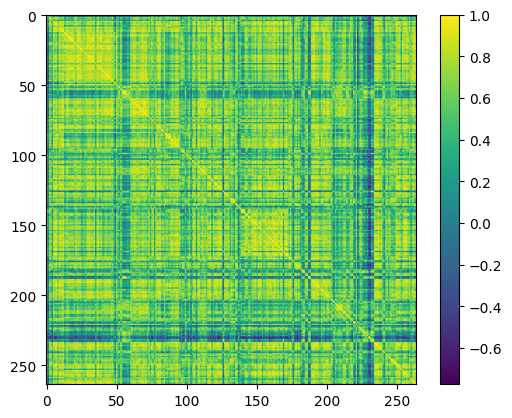

In [18]:
import matplotlib.pyplot as plt

plt.imshow(dfc[-1][5])
plt.colorbar()
plt.show()

In [19]:
a,b = np.triu_indices(264,1)

alldfc = []

for s in dfc:
    for p in s:
        alldfc.append(p[a,b])
        
alldfc = np.stack(alldfc)

print(alldfc.shape)

(4299, 34716)


In [77]:
from sklearn.cluster import KMeans

cls = KMeans(n_clusters=2, n_init='auto').fit(alldfc)

print('Done')

Done


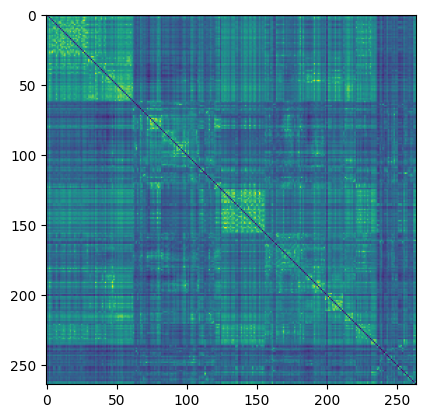

In [82]:
cent = cls.cluster_centers_

plt.imshow(remap(vec2mat(cent[1])))
plt.show()

In [80]:
from sklearn.metrics.pairwise import cosine_similarity

a,b = np.triu_indices(264,1)

cosines = []
ws = []

for j,s in enumerate(dfc):
    avg = cent.shape[0]*[0]
    ws.append(0)
    for p in s:
        w,_,_,_ = np.linalg.lstsq(cent.T, p[a,b], rcond=None)
        ws[-1] += w/len(s)
        for i in range(cent.shape[0]):
            sim = cosine_similarity(cent[i:i+1], np.stack([p[a,b]]))
            avg[i] += sim.squeeze()/len(s)
    cosines.append(avg)
    if j % 10 == 0:
        print(f'Done {j}')
        
print('Complete')
cosines = np.stack(cosines)
ws = np.stack(ws)
print(cosines.shape)
print(ws.shape)

Done 0
Done 10
Done 20
Done 30
Done 40
Done 50
Done 60
Done 70
Done 80
Done 90
Done 100
Done 110
Done 120
Done 130
Done 140
Done 150
Done 160
Done 170
Done 180
Done 190
Done 200
Done 210
Done 220
Done 230
Done 240
Done 250
Done 260
Done 270
Done 280
Done 290
Done 300
Done 310
Done 320
Done 330
Done 340
Done 350
Done 360
Done 370
Done 380
Done 390
Done 400
Done 410
Done 420
Done 430
Done 440
Complete
(441, 2)
(441, 2)


In [67]:
print(ws[:10])
print(sz[:10])

[[ 5.42081765e-02  4.00197307e-01  3.49522295e-01  3.21461513e-02
  -1.34635456e-01  4.57797274e-03 -5.30478914e-03  1.36307425e-01
  -3.05069959e-01  6.53763309e-01]
 [-1.31998992e-01 -5.52218350e-02 -6.55114366e-03  1.06200999e-01
   1.42473434e-01 -7.52400786e-03  1.66145993e-04 -2.36446853e-01
  -1.30280657e-01  1.33710385e+00]
 [-1.24713103e-02 -1.73488326e-01  1.15517988e-01 -6.13074575e-01
  -1.41310189e-01 -9.74788322e-03  2.67241686e-02  1.18016307e+00
   1.19004469e-01  2.77480543e-01]
 [-8.65863561e-02  3.06666562e-01  1.69852807e-01 -4.58822277e-01
   1.42095162e-02 -4.23125797e-03  1.18280849e-02  1.60122287e-01
  -6.36700659e-01  1.68522005e+00]
 [-9.36457972e-02  1.78660915e-01  9.78201015e-01 -4.45026019e-02
   3.61710477e-01  3.48600150e-03 -2.70397272e-02 -3.55783413e-01
  -4.68674322e-01  6.38334554e-01]
 [ 3.76444444e-01  8.64699634e-01 -3.27340428e-02  2.43940976e+00
   7.11043881e-01 -1.27513818e-02  8.30526091e-02 -2.69119733e+00
  -1.57922400e+00  1.69810104e+00

In [83]:
x0 = ws
x1 = fc
y = sz

accs0, accs1 = [], []

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

for _ in range(20):
    xtr0, xt0, xtr1, xt1, ytr, yt = train_test_split(x0, x1, y, stratify=y, train_size=0.8)
    
    reg = LogisticRegression(C=100, max_iter=1000).fit(xtr0, ytr)
    yhat = reg.predict(xt0)
    acc = np.mean(yhat == yt)
    accs0.append(acc)
    s0 = reg.predict_proba(xt0)
    
#     reg = LogisticRegression(C=100, max_iter=5000).fit(xtr1, ytr)
#     yhat = reg.predict(xt1)
#     acc = np.mean(yhat == yt)
#     accs1.append(acc)
#     s1 = reg.predict_proba(xt1)
    
    print(accs0[-1])
    
print('---')
[print(np.mean(accs), np.std(accs)) for accs in [accs0]]

0.6741573033707865
0.6966292134831461
0.6067415730337079
0.5730337078651685
0.7191011235955056
0.5393258426966292
0.5617977528089888
0.6404494382022472
0.5730337078651685
0.651685393258427
0.6629213483146067
0.5730337078651685
0.6292134831460674
0.550561797752809
0.5730337078651685
0.6179775280898876
0.5393258426966292
0.6292134831460674
0.6179775280898876
0.6404494382022472
---
0.6134831460674157 0.050922558173593986


[None]

In [22]:
ours2orig = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 254, 41, 42, 43, 44, 45,
46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85,
86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103,
104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 136, 138, 132,
133, 134, 135, 220, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 185, 186,
187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,
217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
233, 137, 234, 235, 236, 237, 238, 239, 240, 241, 250, 251, 255, 256, 257,
258, 259, 260, 261, 262, 263, 242, 243, 244, 245, 0, 1, 2, 3, 4, 5, 6, 7, 8,
9, 10, 11, 83, 84, 131, 139, 140, 141, 181, 182, 183, 184, 246, 247, 248,
249, 252, 253]

def vec2mat(v):
    a,b = np.triu_indices(264,1)
    m = np.zeros((264,264))
    m[a,b] = v
    return m+m.T

def remap(fc, roimap=ours2orig):
    fc = fc[roimap,:]
    fc = fc[:,roimap]
    return fc

print('Complete')

Complete
